# Descriptive summary stats

In this notebook, we're going to make the following figure panels:

  * Combined VJ usage scatterplots (**Figure 1a** and **Extended Data Figure 2**)
  * Isotype frequency scatterplot (**Figure 1b**)
  * CDR3 length histogram (**Figure 1c**)
  * Germline gene usage heatmaps (**Figure 1e** and **Figure 1f**)
  
The raw data used to make these plots can be found [**here**](LINK).

The following Python packages are required to run the code in this notebook:
  * numpy
  * pandas
  * scipy
  * matplotlib
  * seaborn
  * natsort
  * [abutils](https://www.github.com/briney/abutils)

They can be install by running `pip install numpy pandas scipy matplotlib seaborn natsort abutils`

In [32]:
from __future__ import print_function

from io import StringIO
import itertools
import os
import sys

from natsort import natsorted

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.stats as stats

import numpy as np
import pandas as pd

from abutils.utils import color
from abutils.utils.pipeline import list_files, make_dir

%matplotlib inline

### Subjects and colors

The list of subject colors is maintained throughout all of the figures in the manuscript. It's similar to the standard HLS palette created by Seaborn, but with the 4th and 5th colors modified slightly to make them more distinguishable.

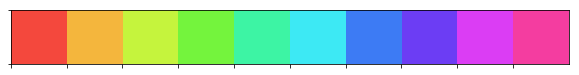

In [22]:
with open('../data_processing/data/subjects.txt') as f:
    subjects = sorted(f.read().split())

colors = sns.hls_palette(10, s=0.9)
colors[3] = sns.hls_palette(11, s=0.9)[3]
colors[4] = sns.hls_palette(12, s=0.9)[5]

color_dict = {s: c for s, c in zip(subjects, colors)}

sns.palplot(colors)

## Combined VJ usage scatterplots

To determine the "reproducibility" of amplification using gene-specific primers, we assessed the frequency of each V-J combination in both technical and biological replicate samples. Technical replicates consist of replicate amplification and sequencing of RNA isolated from the same aliquot of PBMCs. Biological replicates consist of amplification and sequencing of RNA isolated from different aliquots of PBMCs. For each subject, there are 6 biological replicates. Three technical replicates were performed on each biological replicate, for a total of 18 samples per subject.

In [37]:
vcolors = sns.color_palette(['#F34336', '#FE9800', '#3F51B5', '#4CAF50', '#9C27B0', '#03A9F3', '#9E9E9E'])
vcolor_dict = {'IGHV{}'.format(v): c for v, c in zip(range(1, 8), vcolors)}

In [28]:
def vjgene_scatter(df, samples=None, figfile=None, figsize=(6, 6),
                  xlim=(10**-7, 0.1), ylim=(10**-7, 0.1), draw_diag=False,
                  style='white', legend_location='upper right',
                  fill_alpha=0.5, dot_size=15,
                  label_fontsize=14, tick_fontsize=12, legend_fontsize=12):
    # initialize the plot
    sns.set_style(style)
    plt.figure(figsize=figsize)
    plt.xscale('log')
    plt.yscale('log')
    font = {'family': 'sans-serif',
            'color':  'black',
            'weight': 'normal',
            'size': 18,}
    
    # limit the samples, if requested
    if samples is None:
        samples = df.columns.values
    scatter_colors = [vcolor_dict[v[:5]] for v in df.index.values]
        
    # draw the diagonal reference line
    if draw_diag:
        plt.plot(xlim, ylim, 'k--', linewidth=1, alpha=0.8)
    
    # parse and plot data for each pairwise combination of samples
    all_xs = []
    all_ys = []
    for x, y in itertools.combinations(samples, 2):
        all_xs.extend(df[x])
        all_ys.extend(df[y])
        plt.scatter(df[x], df[y], c=scatter_colors, alpha=fill_alpha, s=dot_size, linewidth=0)
    
    # calculate the linear regression statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[x], df[y])
    r_squared = str(round(r_value**2, 4))
    plt.text(6 * 10**-7, 1 * 10**-2, r'$\mathrm{{r^2 = {{{}}}}}$'.format(r_squared), fontdict=font)    
    
    # style the plot
    ax = plt.gca()
    # set axis limits and labels
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel('VJ frequency', fontsize=label_fontsize)
    ax.set_xlabel('VJ frequency', fontsize=label_fontsize)
    # style the ticks
    ax.tick_params(axis='x', labelsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)
    # remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # configure the legend
    handles = [plt.Line2D([0,0], [0,0], color=c, marker='o', linestyle='', alpha=0.5) for c in vcolors]
    ax.legend(handles, ['VH{}'.format(i) for i in range(1, 8)], loc='lower right', fontsize=12, borderpad=1.5)
    
    # show or save
    if figfile is not None:
        plt.savefig(figfile)
    else:
        plt.show()

#### Load VJ usage data

In our manuscript, we plotted VJ usage for three distinct sets of data:
  * sequences of all isotypes
  * just IgM sequences
  * just IgG sequences
  
By default, the figures made in this notebook will use data from sequences of all isotypes. To used a different dataset, uncomment the dataset you wish to use and comment out all other datasets.

In [30]:
# all sequences
ifile = '../data_processing/data/descriptive_stats/vj_frequency.txt'

# just IgM
# ifile = '../data_processing/data/descriptive_stats/vj_frequency_IgM.txt'

# just IgG
# ifile = '../data_processing/data/descriptive_stats/vj_frequency_IgG.txt'

with open(ifile) as f:
    subject_vj_data = f.read().split('#')[1:]

vj_dfs = {}
    
for vj in subject_vj_data:
    subject = vj.split('\n')[0].strip()
    data = '\n'.join(vj.split('\n')[1:])
    df = pd.read_table(StringIO(data),
                       header=None,
                       names=['count{}'.format(i) for i in range(1, 19)], 
                       sep='\s+', index_col=0)
    vj_dfs[subject] = df

#### Biological replicates

To make the notebook more easily readable when being rendered on Github, only one plot will be made (for a single subject). If you'd like to make plots for all subjects, comment out the `SUBJECT_LIMIT = 1` line and uncomment the `SUBJECT_LIMIT = None` line.

316188: all


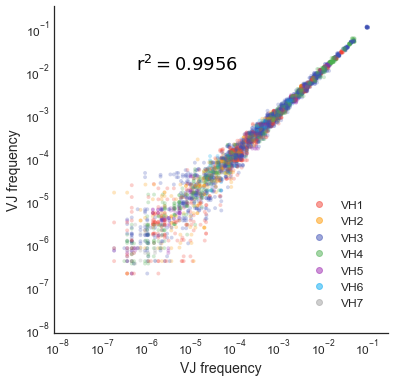

In [34]:
SUBJECT_LIMIT = 1
# SUBJECT_LIMIT = None

for subject in subjects[:SUBJECT_LIMIT]:
    print(subject, end='')
    df = vj_dfs[subject]
    
    # pool technical replicates so that there's a single
    # column for each biological replicate
    biorep_columns = []
    for i in range(6):
        columns = ['count{}'.format(i + j) for j in [1, 7, 13]]
        biorep_columns.append('biorep{}'.format(i + 1))
        df['biorep{}'.format(i + 1)] =  df[columns].sum(axis=1)
    
    # normalize
    df = df / df.sum()
    
    # plot
    if 'IgM' in ifile:
        isotype = 'IgM'
    elif 'IgG' in ifile:
        isotype = 'IgG'
    else:
        isotype = 'all'
    print(':', isotype)
    vjgene_scatter(df[biorep_columns], fill_alpha=0.25,
                   xlim=(8 * 10**-9, 0.3), ylim=(8 * 10**-9, 0.3),
#                    figfile='./figures/{}_vj-frequencies_bioreps_{}.pdf'.format(subject, isotype)
                  )

#### Technical replicates

To make the notebook more easily readable, only one plot will be made (for a single subject). If you'd like to make plots for all subjects, comment out the `SUBJECT_LIMIT = 1` line and uncomment the `SUBJECT_LIMIT = None` line.

316188: all


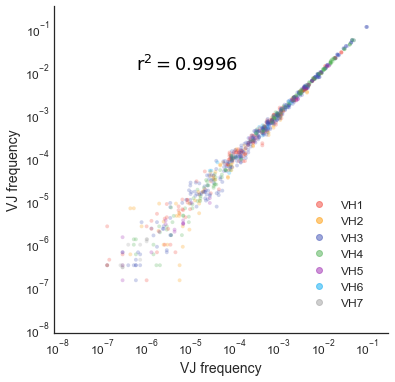

In [38]:
SUBJECT_LIMIT = 1
# SUBJECT_LIMIT = None

for subject in subjects[:SUBJECT_LIMIT]:
    print(subject, end='')
    df = vj_dfs[subject]
    
    # pool technical replicates so that there's a single
    # column for each biological replicate
    techrep_columns = []
    for i in [1, 7, 13]:
        columns = ['count{}'.format(i + j) for j in range(6)]
        techrep_columns.append('techrep{}'.format(i + 1))
        df['techrep{}'.format(i + 1)] =  df[columns].sum(axis=1)
    
    # normalize
    df = df / df.sum()
    
    # plot
    if 'IgM' in ifile:
        isotype = 'IgM'
    elif 'IgG' in ifile:
        isotype = 'IgG'
    else:
        isotype = 'all'
    print(':', isotype)
    vjgene_scatter(df[techrep_columns], fill_alpha=0.25,
                   xlim=(8 * 10**-9, 0.3), ylim=(8 * 10**-9, 0.3),
#                    figfile='./figures/{}_vj-frequencies_bioreps_{}.pdf'.format(subject, isotype)
                  )

## Isotype frequency scatterplot

First we load the isotype frequency data and transform into a DataFrame:

In [43]:
isotype_data = []
igms = []
iggs = []

with open('../data_processing/data/descriptive_stats/isotype-frequency_by-biorep.txt') as f:
    iso_data = f.read().split('#')[1:]

for i in iso_data:
    subject = i.split('\n')[0].strip()
    subjects.append(subject)
    for line in i.split('\n')[1:]:
        l = line.strip().split()
        if l:
            igm, igg = float(l[0]), float(l[1])
            total = sum([igm, igg])
            igms.append(igm / total)
            iggs.append(igg / total)
            isotype_data.append({'subject': subject, 'Isotype': 'IgM', 'Frequency': igm / total})
            isotype_data.append({'subject': subject, 'Isotype': 'IgG', 'Frequency': igg / total})

isotype_df = pd.DataFrame(isotype_data).sort_values(by='subject')

By default, the figure will be shown inline and not saved. To save the plot, comment out the `plt.show()` line and uncomment the last two lines of the code block.

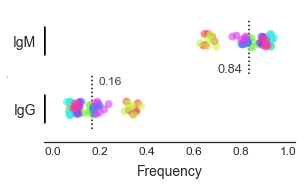

In [42]:
# initialize the plot
sns.set_style('white')
plt.figure(figsize=(4.5, 2.5))

# plot the isotype data
sns.stripplot(data=isotype_df, y='Isotype', x='Frequency', hue='subject', order=['IgM', 'IgG'],
              size=8, palette=color_dict, jitter=True, alpha=0.6, orient='h')

# plot the vertical reference lines

#style the plot
ax = plt.gca()
# set axis limits and labels
ax.set_xlim([-0.04, 1.03])
ax.set_ylabel('Isotype', size=0, labelpad=4)
ax.set_xlabel('Frequency', size=14, labelpad=8)
# set tick params
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=14, length=0, width=1.25, pad=8, right=False)
# hide top, left and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# plot the mean IgM frequency
plt.axvline(x=np.mean(igms), ymin=0.5, ymax=0.9, color='k', linestyle='dotted')
ax.text(np.mean(igms) - 0.03,
        0.475,
        round(np.mean(igms), 2),
        color=[0.25] * 3,
        fontsize=13,
        horizontalalignment='right')
# plot the mean IgG frequency
plt.axvline(x=np.mean(iggs), ymin=0.1, ymax=0.5, color='k', linestyle='dotted')
ax.text(np.mean(iggs) + 0.03,
        0.65,
        round(np.mean(iggs), 2),
        color=[0.25] * 3,
        fontsize=12,
        horizontalalignment='left')
# plot the segmented y-axis spines
plt.axvline(x=-0.04, ymin=0.15, ymax=0.35, color='k', linewidth=2.5)
plt.axvline(x=-0.04, ymin=0.65, ymax=0.85, color='k', linewidth=2.5)
# plot the legend
ax.legend().set_visible(False)

# show or save
plt.show()
# plt.tight_layout()
# plt.savefig('./figures/isotype-frequency_scatter.pdf')

## CDR3 length histogram

In [48]:
def cdr3_length_histogram(df, color_dict, figfile=None, figsize=(6.5, 4),
                          style='white', legend_location='upper right',
                          shade=False, shade_alpha=0.1, legend=True,
                          ylim=(0, 0.16), xlim=(0, 40),
                          label_fontsize=14, tick_fontsize=12, legend_fontsize=13):
    # initialize the plot
    sns.set_style(style)    
    plt.figure(figsize=figsize)
    
    # plot the data
    for subject in subjects:
        color = color_dict[subject]
        xs = df.index.values
        ys = df[subject]
        plt.plot(xs, ys, c=color, alpha=0.8, label=subject)
        if shade:
            shade_lower = [0] * len(xs)
            plt.fill_between(x=xs, y1=shade_lower, y2=ys, color=color, alpha=shade_alpha)
    
    # style the plot
    ax = plt.gca()
    # set axis limits and labels
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel('Frequency', fontsize=label_fontsize, labelpad=6)
    ax.set_xlabel('CDR3 length (AA)', fontsize=label_fontsize)
    # style ticks
    locs = ax.get_yticks()
    ax.set_yticks(np.arange(0, 0.14, 0.02))
    ax.tick_params(axis='x', which='major', labelsize=tick_fontsize)
    ax.tick_params(axis='y', which='major', labelsize=tick_fontsize, length=6, width=1.25, pad=6, right=False)
    # hide top, left and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # configure the legend
    if legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc=legend_location, fontsize=legend_fontsize)
    
    # save or show
    if figfile is not None:
        plt.tight_layout()
        plt.savefig(figfile)
    else:
        plt.show()

By default, the figure will be shown inline and not saved. To save the plot, uncomment the `figfile=...` line.

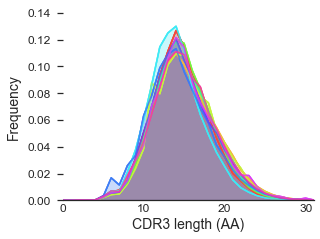

In [47]:
# load the data
with open('../data_processing/data/descriptive_stats/cdr3-lengths.txt') as f:
    cdr3_data = f.read().split('#')[1:]
data = {}
for d in cdr3_data:
    subject = d.split('\n')[0].strip()
    data[subject] = {}
    for line in d.split('\n')[1:]:
        l = line.strip().split()
        if l:
            muts, count = float(l[0]), float(l[1])
            data[subject][muts] = count

# convert to a DataFrame and normalize
cdr3_df = pd.DataFrame(data).fillna(0)
norm_cdr3_df = cdr3_df / cdr3_df.sum()

# make the plot
cdr3_length_histogram(norm_cdr3_df, color_dict,
                      ylim=(0, .14), xlim=(0, 30.99),
                      shade=True, figsize=(4.5, 3.45),
                      legend=False,
#                       figfile='./figures/cdr3-lengths.pdf'
                     )

## Germline gene usage heatmaps

In [16]:
def germline_gene_heatmap(df, figfile=None, figsize=None):
    # initialize the figure
    if figsize is not None:
        plt.figure(figsize=figsize)
    else:
        plt.figure()

    # plot each subject's data separately so that we can color them separately
    for i, donor in enumerate(df.columns.values[::-1]):
        matrix = np.empty([d + 1 for d in df.shape][::-1])
        matrix[:] = np.NAN
        freqs = list((df[donor] - df[donor].min()) / (df[donor].max() - df[donor].min()))
        matrix[i] = np.asarray(freqs + [np.NAN])
        masked = np.ma.masked_where(np.isnan(matrix), matrix)
        cmap = color.get_cmap(from_color=color_dict[donor])
        plt.pcolormesh(masked, cmap=cmap, edgecolor='w', linewidth=4)

    # style the plot
    ax = plt.gca()
    ax.set_ylim([0, len(subjects)])
    ax.set_xlim([0, df.shape[0]])
    ax.axes.get_xaxis().set_ticks([0.5 + d for d in range(df.shape[0])])
    ax.axes.get_xaxis().set_ticklabels(df.index.values, fontsize=28, rotation='vertical')
    ax.axes.get_yaxis().set_ticks([0.5 + d for d in range(df.shape[1])])
    ax.axes.get_yaxis().set_ticklabels(df.columns.values[::-1], fontsize=32)
    ax.tick_params(axis='y', pad=12)
    for position in ['right', 'left', 'top', 'bottom']:
        ax.spines[position].set_visible(False)
    ax.set_aspect('equal')
    
    # show or save
    if figfile is not None:
        plt.tight_layout()
        plt.savefig(figfile)
    else:
        plt.show()

#### V-gene usage heatmap

If you'd like to save the figure to file, rather than just show it inline, uncomment the `figfile=...` line.

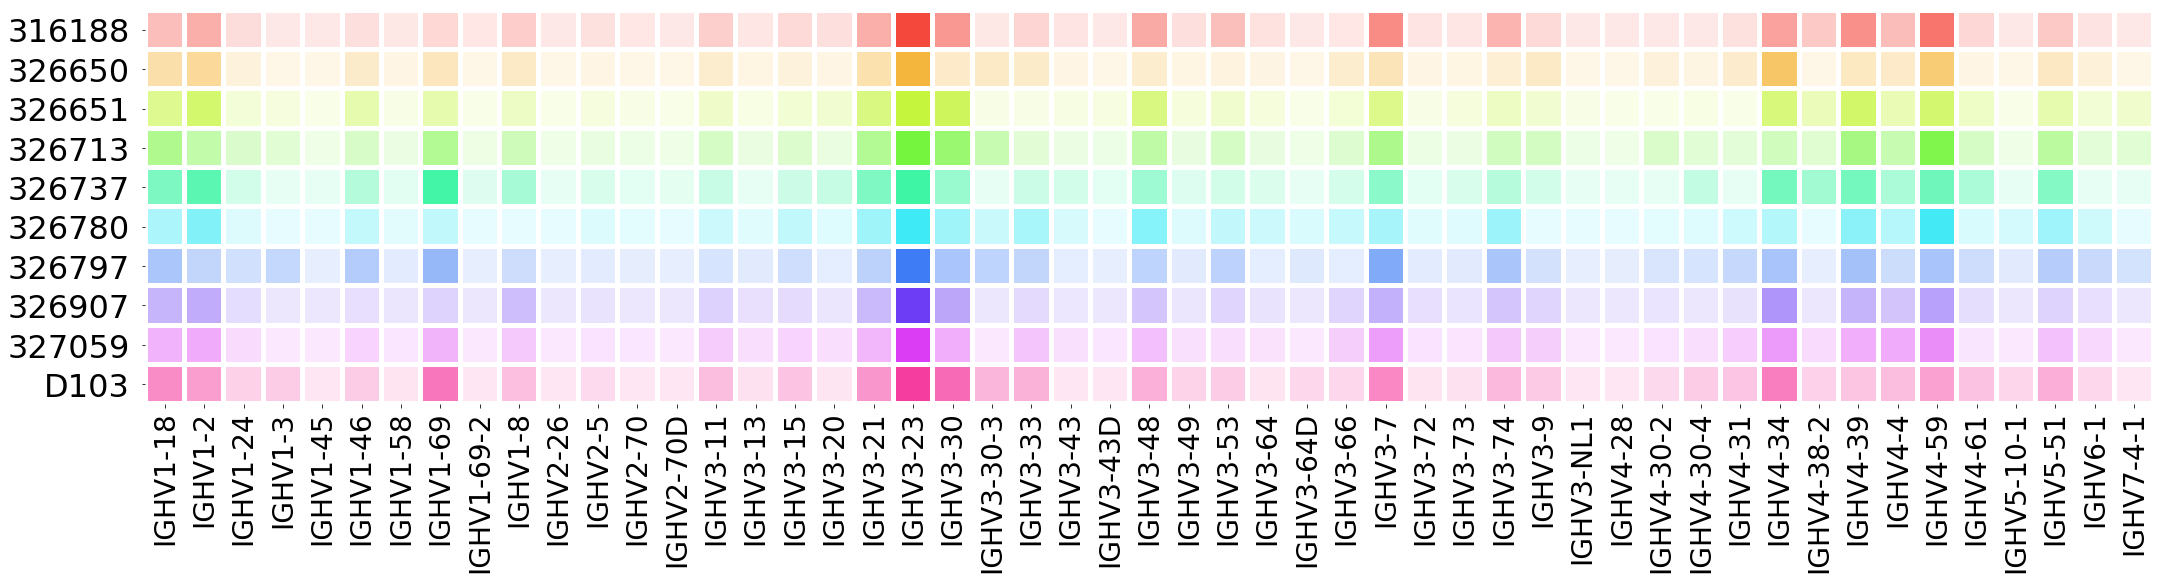

In [18]:
# load the data
with open('../data_processing/data/descriptive_stats/vgene_frequency.txt') as f:
    subject_data = f.read().split('#')[1:]
data = {}
for sd in subject_data:
    subject = sd.split('\n')[0].strip()
    data[subject] = {}
    for line in sd.split('\n')[1:]:
        l = line.strip().split()
        if l:
            vgene, count = l[0], float(l[1])
            data[subject][vgene] = count

# convert to a DataFrame and normalize
df = pd.DataFrame(data).fillna(0)
norm_df = df / df.sum()

# plot the data
germline_gene_heatmap(norm_df, figsize=[36, 12],
#                       figfile='./figures/vgene-usage_heatmap.pdf'
                     )

#### J-gene usage heatmap

If you'd like to save the figure to file, rather than just show it inline, uncomment the `figfile=...` line.

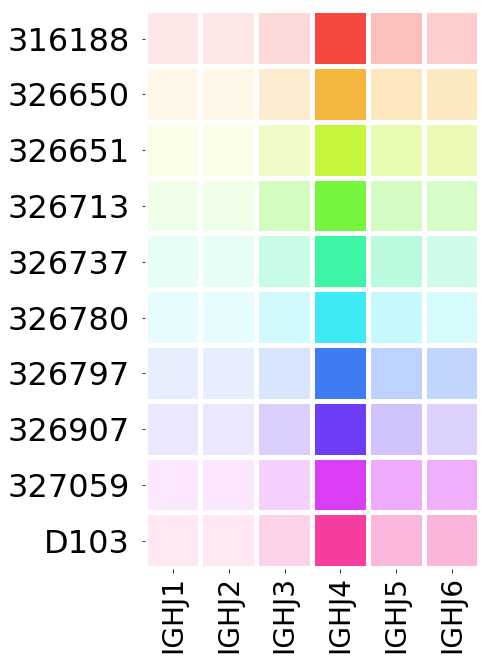

In [19]:
# load the data
with open('../data_processing/data/descriptive_stats/jgene_frequency.txt') as f:
    subject_data = f.read().split('#')[1:]
data = {}
for sd in subject_data:
    subject = sd.split('\n')[0].strip()
    data[subject] = {}
    for line in sd.split('\n')[1:]:
        l = line.strip().split()
        if l:
            vgene, count = l[0], float(l[1])
            data[subject][vgene] = count

# convert to a DataFrame and normalize
df = pd.DataFrame(data).fillna(0)
norm_df = df / df.sum()

# plot the data
germline_gene_heatmap(norm_df, figsize=[6, 12],
#                       figfile='./figures/jgene-usage_heatmap.pdf'
                     )